In [8]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import os
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve
from sklearn.metrics import auc
from sklearn.model_selection import train_test_split

In [9]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

In [10]:
sig_data = h5py.File("data_files_for_AD/lifetime_1ns_0.005GeV.hdf5")

In [11]:
bg_data = h5py.File("data_files_for_AD/gamma_1.hdf5")

In [12]:
sig_data.keys()

<KeysViewHDF5 ['energy', 'layer_0', 'layer_1', 'layer_2', 'overflow']>

In [13]:
def create_dataset_wlabels(sig_data,bg_data):
    sig_layer_0 = sig_data['layer_0'][:]/1e3
    sig_layer_1 = sig_data['layer_1'][:]/1e3
    sig_layer_2 = sig_data['layer_2'][:]/1e3
    
    sig_E0 = sig_layer_0.sum(axis=(-1, -2))
    sig_E1 = sig_layer_1.sum(axis=(-1, -2))                    
    sig_E2 = sig_layer_2.sum(axis=(-1, -2))
              
    sig_Edep = (sig_E0 + sig_E1 + sig_E2).reshape(-1,1)
    sig_Einc = sig_Edep/0.937
    #sig_Einc = sig_data['energy'][:]+mass
    
    sig_layer_0 = sig_layer_0.reshape(-1,288)
    sig_layer_1 = sig_layer_1.reshape(-1,144)
    sig_layer_2 = sig_layer_2.reshape(-1,72)
    
    sig_voxels = np.concatenate((sig_layer_0,sig_layer_1,sig_layer_2),axis=1)
    
    bg_layer_0 = bg_data['layer_0'][:]/1e3
    bg_layer_1 = bg_data['layer_1'][:]/1e3
    bg_layer_2 = bg_data['layer_2'][:]/1e3
                             
    bg_E0 = bg_layer_0.sum(axis=(-1, -2))
    bg_E1 = bg_layer_1.sum(axis=(-1, -2))                       
    bg_E2 = bg_layer_2.sum(axis=(-1, -2))
    
    bg_Edep = (bg_E0 + bg_E1 + bg_E2).reshape(-1,1)
    #bg_Einc = bg_data['energy'][:]
    bg_Einc = bg_Edep/0.937
    
    bg_layer_0 = bg_layer_0.reshape(-1,288)
    bg_layer_1 = bg_layer_1.reshape(-1,144)
    bg_layer_2 = bg_layer_2.reshape(-1,72)
    
    bg_voxels = np.concatenate((bg_layer_0,bg_layer_1,bg_layer_2),axis=1)
    
    sig_voxels = sig_voxels/(sig_Einc.reshape(-1,1)+1e-16)
    bg_voxels = bg_voxels/(bg_Einc.reshape(-1,1)+1e-16)
    
    final_sig_data = np.concatenate([np.log10(sig_Einc.reshape(-1,1)+1e-16), sig_voxels], axis=1)
    final_bg_data = np.concatenate([np.log10(bg_Einc.reshape(-1,1)+1e-16), bg_voxels], axis=1)
    
    sig_labels = np.ones_like(sig_Einc.reshape(-1,1))
    bg_labels = np.zeros_like(bg_Einc.reshape(-1,1))

    X = np.concatenate([final_sig_data,final_bg_data],axis=0)
    y = np.concatenate([sig_labels,bg_labels],axis=0)

    return X, y

In [14]:
mass = 0.005
X,y = create_dataset_wlabels(sig_data,bg_data)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)

In [15]:
print("X_train shape: ",X_train.shape)
print("X_val shape: ",X_val.shape)
print("X_test shape: ",X_test.shape)

print("y_train shape: ",y_train.shape)
print("y_val shape: ",y_val.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (120000, 505)
X_val shape:  (40000, 505)
X_test shape:  (40000, 505)
y_train shape:  (120000, 1)
y_val shape:  (40000, 1)
y_test shape:  (40000, 1)


In [16]:
from keras.models import Sequential
from keras.layers import Dense

model = Sequential()
model.add(Dense(512, activation='relu', input_dim=505))
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

2023-12-15 07:51:00.753368: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-15 07:51:11.482416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-12-15 07:51:24.225319: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1960] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 512)               259072    
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                                 
Total params: 522241 (1.99 MB)
Trainable params: 522241 (1.99 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [18]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])


In [19]:
from keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('weights_best.hdf5',
                             save_weights_only=True,save_best_only=True,
                             monitor='val_loss',
                             mode='min')

In [20]:
# Train model
history = model.fit(X_train, y_train,
          epochs=50,
          batch_size=1000,
          validation_data=(X_val, y_val),callbacks=[checkpoint])

Epoch 1/50
120/120 [==============================] - 3s 13ms/step - loss: 0.6322 - accuracy: 0.6035 - val_loss: 0.6080 - val_accuracy: 0.6218
Epoch 2/50
120/120 [==============================] - 1s 10ms/step - loss: 0.6009 - accuracy: 0.6318 - val_loss: 0.5953 - val_accuracy: 0.6410
Epoch 3/50
120/120 [==============================] - 1s 10ms/step - loss: 0.5949 - accuracy: 0.6357 - val_loss: 0.5930 - val_accuracy: 0.6409
Epoch 4/50
120/120 [==============================] - 1s 11ms/step - loss: 0.5929 - accuracy: 0.6370 - val_loss: 0.5923 - val_accuracy: 0.6405
Epoch 5/50
120/120 [==============================] - 1s 12ms/step - loss: 0.5917 - accuracy: 0.6387 - val_loss: 0.5975 - val_accuracy: 0.6381
Epoch 6/50
120/120 [==============================] - 1s 11ms/step - loss: 0.5914 - accuracy: 0.6385 - val_loss: 0.5919 - val_accuracy: 0.6409
Epoch 7/50
120/120 [==============================] - 1s 11ms/step - loss: 0.5928 - accuracy: 0.6375 - val_loss: 0.5942 - val_accuracy: 0.6381

In [21]:
y_out=model.predict(X_test)
# Get ROC curve
fpr, tpr, thresholds = roc_curve(y_test[:], y_out[:])

# Calculate AUC
roc_auc = auc(fpr, tpr)

print("AUC = ", roc_auc)

1250/1250 [==============================] - 2s 2ms/step
AUC =  0.6993085168049482


# Evaluate on data it was trained on (with fixed energy)

In [22]:
model.load_weights('weights_best.hdf5')

In [23]:
def combine_test_files(data1, data2):

    np.random.shuffle(data1)
    np.random.shuffle(data2)
    val = np.concatenate([data1, data2], axis=0)
    np.random.shuffle(val)
    return val

In [24]:
mass = 0.005
lifetime = 1
sig_data = h5py.File("files_fixed_disp/lifetime_"+str(lifetime)+"ns_"+str(mass)+"GeV.hdf5")

In [25]:
bg_data = h5py.File("data_files_for_AD/gamma_2.hdf5")

In [26]:
X_eval,y_eval = create_dataset_wlabels(sig_data,bg_data)

In [27]:
y_out=model.predict(X_eval)

6250/6250 [==============================] - 11s 2ms/step


In [28]:
# Get ROC curve
fpr, tpr, thresholds = roc_curve(y_eval[:], y_out[:])

# Calculate AUC
roc_auc = auc(fpr, tpr)

print("AUC = ", roc_auc)

AUC =  0.71337922805


In [29]:
roc = np.array([fpr,tpr])

In [30]:
np.savetxt("lifetime_1ns_0.005GeV_roc.txt", roc)

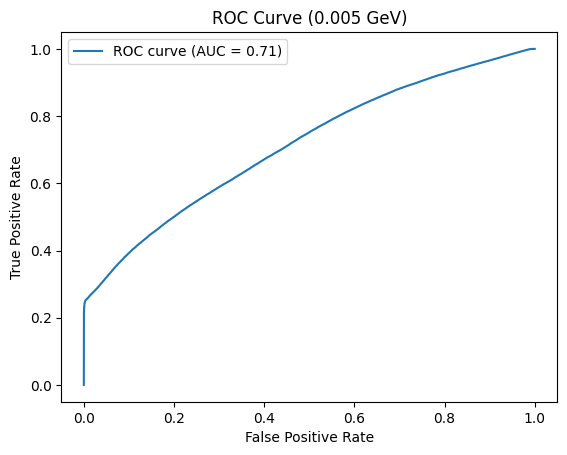

In [31]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.legend()
plt.title('ROC Curve (0.005 GeV)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()

# Evaluate on other data (with fixed energy)

In [103]:
mass = 5
lifetime = 1
sig_data = h5py.File("files_fixed_disp/lifetime_"+str(lifetime)+"ns_"+str(mass)+"GeV.hdf5")
name = "lifetime_"+str(lifetime)+"ns_"+str(mass)+"GeV"

In [104]:
sig_data = h5py.File("files_fixed_disp/"+name+".hdf5")

In [105]:
X_eval,y_eval = create_dataset_wlabels(sig_data,bg_data)

In [106]:
y_out=model.predict(X_eval)

6250/6250 [==============================] - 11s 2ms/step


In [107]:
# Get ROC curve
fpr, tpr, thresholds = roc_curve(y_eval[:], y_out[:])

# Calculate AUC
roc_auc = auc(fpr, tpr)

print("AUC = ", roc_auc)

AUC =  0.8637026304


In [108]:
roc = np.array([fpr,tpr])
roc_filename = name+"_roc.txt"
np.savetxt(roc_filename, roc)

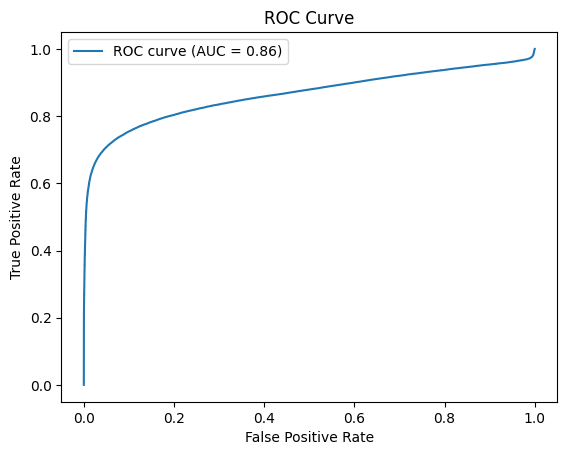

In [109]:
# Plot ROC curve
plt.plot(fpr, tpr, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.legend()
plt.title('ROC Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()